# An Attempt at Polynomial Regression

This notebook is designed to write and explore multiple polynomial regression. There is also an attempt at writing various gradient descent algorithms.

### Setup

In [31]:
# Sets up directories and files for a new project
from pathlib import Path

cwd = Path.cwd()
graph_dir = cwd / 'Graphs'

def CreateDir(directory: Path, logging: bool=False) -> None:
    
    # If the directory already exists, return None
    if directory.exists():
        
        # If logging is enabled, print a message
        if logging==True:
            print(f'Directory {directory} already exists.')
    
        return None
    
    else:
        if logging==True:
            print(f'Creating directory ...')
            Path.mkdir(directory, exist_ok=True, parents=True)
            print(f'Directory {directory} created.')
        else:
            Path.mkdir(directory, exist_ok=True, parents=True)
    
    return None
    
def CreateFilePath(fname: str, dir: str = graph_dir,
                    extension: str = 'png') -> str:
    
    # Replace spaces with underscores
    fname = fname.replace(' ', '_')
    
    # Creates parent directory if it doesn't exist
    CreateDir(directory=dir, logging=False)
    
    # Returns the full path
    return f'{dir}{'\\'}{fname}.{extension}'

CreateDir(graph_dir, logging=True)

Directory c:\Users\giaco\Documents\GitHub\ML-Practice\Notebooks\Polynomial-Regression\Graphs already exists.


In [32]:
# Sets up plotting and other packages
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Any, Tuple, Optional
from numpy.typing import NDArray
from itertools import combinations_with_replacement as cwr

# Changes the default font size, linewidth, and figure size
plt.rcParams.update({'font.size': 14,
                        'lines.linewidth': 2,
                        'figure.figsize': (10, 8),
                        'figure.titlesize': 18,
                        'axes.labelsize': 16,
                        'axes.titlesize': 18,
                        'axes.linewidth': 2,
                        'xtick.labelsize': 14,
                        'ytick.labelsize': 14,
                        'legend.fontsize': 14,
                        'legend.title_fontsize': 16,
                        'legend.shadow': True,
                        'legend.frameon': True,
                        'legend.edgecolor': 'black',
                        'legend.facecolor': 'white',
                        'legend.fancybox': True,
                        'legend.framealpha': 1,
                        'legend.borderpad': 1,
                        'legend.labelspacing': 1,
                        'legend.handletextpad': 1,
                        'legend.handlelength': 1.5,
                        'legend.borderaxespad': 1,
                        'legend.columnspacing': 2})

## Helper Functions

In [33]:
def ReshapeTo(arr: NDArray[Any],
                required_shape: Tuple[int, ...]) -> Optional[NDArray[Any]]:
    """Reshapes array to required shape. If current shape matches original array,
        does not reshape. If array cannot be reshaped to required shape

    Args:
        arr (NDArray[Any]): Array to be reshaped
        required_shape (Tuple[int, ...]): Array shape to which arr needs to be reshaped to

    Returns:
        Optional[NDArray[Any]]: Reshaped array
    """
    
    # Checks whether array has already required shape
    if arr.shape == required_shape:
        return arr
    
    # If not required shape, try to reshape
    try:
        reshaped_arr = arr.reshape(required_shape)
        return reshaped_arr
    
    except ValueError as e:
        print(f"Cannot reshape array from shape {arr.shape} to {required_shape}: {e}")
        return None
        
    return 

def AddRandomNoise(arr, scale: float = 0.1) -> NDArray:
    """Adds random noise to array

    Args:
        arr (NDArray): Array to which noise is to be added
        scale (float, optional): Scale of noise. Defaults to 0.1.

    Returns:
        NDArray: Array with random noise added
    """
    
    # Generates noise
    noise = np.random.normal(loc=0, scale=scale, size=arr.shape)
    
    # Adds noise to array
    noisy_arr = arr + noise
    
    return noisy_arr

def FormString(num: int|float) -> str:
    """Forms string from number

    Args:
        num (int|float): Number to be converted to string

    Returns:
        str: String representation of number
    """
    
    if num >= 0:
        return f'+{num}'
    else:
        return f'{num}'

## Polynomial Model and Cost Function

In [51]:
def CreateGrid(ranges: list[Tuple[(Any, Any)], ...], num: int=100, transpose=True) -> NDArray[Any]:
    """
    Generates a parameter grid based on the given parameter ranges.
    Parameters:
    - ranges: A list of tuples representing the ranges for each parameter.
                    Each tuple should contain the start and end values of the range.
    - num: The number of points to generate along each parameter range. Default is 100.
    Returns:
    - parameter_grid: A numpy array representing the parameter grid.
                    The shape of the grid is (num, N), where N is the number of parameters.
    Example:
    >>> ranges = [(0, 1), (2, 3), (4, 5)]
    >>> grid = CreateParamGrid(ranges, num=1000)
    >>> print(grid.shape)
    (1000, 3)
    """
    
    # Generates a meshgrid of parameters based on the given list of ranges
    # Iterates over each tuple in the list and generates a 1-D array of values, saved within a list
    # Then it uses np.meshgrid() to create a meshgrid of parameters by unpacking the list
    grid = np.meshgrid(*[np.linspace(start, end, num) for (start, end) in ranges], indexing='ij')
    
    # Stacks parameters into a grid
    # np.ndarray.ravel() returns a contiguous flattened array
    # np.stack() stacks the flattened arrays along the last axis
    # The shape of the parameter grid is (num, N) where N is the number of parameters
    grid_flattened = np.stack([param.ravel() for param in grid], axis=-1)
    
    if transpose:
        grid_flattened = grid_flattened.T
    
    return grid, grid_flattened

def FormPredictorMatrix(predictors: NDArray[Any], order: int=1, include_interaction: bool=True) -> NDArray[Any]:
    """
    Generates a predictor matrix for polynomial regression models.

    This function takes an array of predictor variables and constructs a matrix
    where each column corresponds to a power of the predictor variables up to the specified order.
    It also includes a column of ones to account for the intercept term in the regression model.

    Args:
        predictors (NDArray[Any]): A 1-D (One predictor), 2-D (Multiple predictors) array of predictor variables.
                                    Each row represents a different observation, and each column represents a different predictor variable.
        order (int, optional): The highest power to which the predictor variables should be raised. Defaults to 1 (Linear).
        include_interaction (bool, optional): Whether to include interaction terms between the predictor variables. Defaults to True.

    Returns:
        NDArray[Any]: A 2-D array where each row corresponds to an observation and each column corresponds to a predictor
                    variable raised to a power from 1 to the specified order. The first column is a column of ones for the intercept term.
                    Result is [1, x1, x2, x1^2, x1x2, x2^2, ...] for a polynomial of order 2 with two predictors.

    Examples:
        >>> predictors = np.array([1, 2, 3])
        >>> FormPredictorMatrix(predictors, order=2)
        array([[1., 1., 1.],
                [1., 2., 4.],
                [1., 3., 9.]])
            
        >>> predictors = np.array([[1, 4], [2, 5], [3, 6]])
        >>> FormPredictorMatrix(predictors, order=2)
        array([[ 1.  1.  4.  1. 4. 16.]
                [ 1.  2.  5.  4. 10. 25.]
                [ 1.  3.  6.  9. 9. 36.]])
        
        >>> predictors = np.array([[1, 4], [2, 5], [3, 6]])
        >>> FormPredictorMatrix(predictors, order=2, include_interaction=False)
        array([[ 1.  1.  4.  1. 16.]
                [ 1.  2.  5.  4. 25.]
                [ 1.  3.  6.  9. 36.]])
        
    """
    assert predictors.ndim in [1, 2], "Predictors should be a 1-D or 2-D array"
        
    
    if predictors.ndim==1: #If only one predictor
        predictors = predictors.reshape(-1, 1)
    
    if include_interaction==False:
        # Ensures input is array
        predictors = np.asarray(predictors)
        
        # Creates array of exponents
        exponents = np.arange(1, order+1)
        
        # Reshapes exponenent array for braodcasting to predictors
        exponents_shape = (*exponents.shape,) + (1,)*(predictors.ndim)
        exponents = exponents.reshape(exponents_shape)
        
        # Computes predictor matrix
        predictor_matrix = predictors**exponents
        
        # Moves exponent axis to the last axis
        predictor_matrix = np.moveaxis(predictor_matrix, source=0, destination=-2)
        
        # Collapses the exponents axis
        predictor_matrix = predictor_matrix.reshape((*predictors.shape[:-1], predictors.shape[-1]*order))
        
        # Adds column of ones for intercept
        predictor_matrix = np.concatenate((np.ones((*predictors.shape[:-1], 1)), predictor_matrix), axis=-1)
        
    else:
        predictor_matrix = predictors.copy()
        for degree in range(2, order+1): #Iterates over the degrees
            
            # Transposes predictors matrix to iterate over predictors i.e. columns -> first axis
            # Necessary as combinations are formed by slicing over first axis
            transposed_predictors = np.moveaxis(predictor_matrix, source=-1, destination=0) #Transposes predictors matrix to iterate over predictors
            
            # Computes combinations of predictors for specified degree
            combinations = cwr(transposed_predictors, degree) 
            
            # Iterates over combinations and computes product of predictors
            for comb in combinations:
                
                #Computes product of combinations and reshapes to column vector
                prod_comb = np.prod(comb, axis=0).reshape(*predictors.shape[:-1], 1) 
                
                predictor_matrix = np.concatenate((predictor_matrix, prod_comb), axis=-1)
    
        # Adds column of ones for intercept
        predictor_matrix = np.concatenate((np.ones((*predictors.shape[:-1], 1)), predictor_matrix), axis=-1)
    
    return predictor_matrix
    

def PolynomialModel(predictors_matrix: NDArray[Any],
                    params: NDArray[Any]) -> NDArray[Any]:
    
    """ 
    Computes the model response for a polynomial regression model.

    This function takes a matrix of predictor variables and a corresponding array of parameters
    to compute the predicted response values for a polynomial regression model. The predictor matrix
    should include columns for each predictor variable raised to the appropriate power, and the parameters
    array should include the intercept term followed by the coefficients for each predictor variable.

    Args:
        predictors_matrix (NDArray[Any]): An array where each row represents an observation and each column
                                        represents a predictor variable raised to a power from 1 to the specified order.
                                        The first column should be a column of ones for the intercept term.
                                        i.e. [1, x1, x1^2, x2, x2^2, ...] for a polynomial of order 2.
        params (NDArray[Any]): A 1-D or 2-D array of parameters for the model. The first element is the intercept term,
                                and the remaining elements are the coefficients for the predictor variables.

    Returns:
        NDArray[Any]: A 1-D array of predicted response values for each observation.

    Example:
        >>> predictors_matrix = np.array([[1, 1, 1], [1, 2, 4], [1, 3, 9]])
        >>> params = np.array([0.5, 1.0, 2.0])
        >>> PolynomialModel(predictors_matrix, params)
        array([ 3.5,  9.5, 19.5])
    """
    
    # Asserts correct shape of predictors
    #assert params.shape[0]==predictors_matrix.shape[-1], "Same number of entries as the number of columns of predictor matrix"
    
    # Reshapes param array
    if params.ndim==1:
        params = params.reshape(-1, 1)
    
    return np.matmul(predictors_matrix, params)

def MeanSquareError(model: Callable[[NDArray[Any], NDArray[Any]], NDArray[Any]],
                    response: NDArray[Any],
                    predictors: list[NDArray[Any]],
                    params: NDArray[Any]) -> NDArray[Any]:
    
    assert predictors.shape[-1]==params.shape[0]
    
    difference = (response - model(predictors, params))  #Computes difference between measured and model response as 1-D array 
    mean_squared_error = (difference.T).dot(difference)  #Squares error
    mean_squared_error /= response.shape[0]               #Takes average
    
    return mean_squared_error

## Testing The Functions

In [35]:
# Tests CreateParamGrid
param_ranges = [(0, 1), (2, 3), (4, 5)]
grid, grid_flattened = CreateGrid(param_ranges, num=2)
print(f'Parameter Grid: \n -Shape: {grid_flattened.shape} \n -Values: \n {grid_flattened}\n')

Parameter Grid: 
 -Shape: (3, 8) 
 -Values: 
 [[0. 0. 0. 0. 1. 1. 1. 1.]
 [2. 2. 3. 3. 2. 2. 3. 3.]
 [4. 5. 4. 5. 4. 5. 4. 5.]]



In [36]:
# Tests FormPredictorMatrix
predictors = np.array([1, 2, 3, 4, 5, 6]).reshape(2, 3).T
print(f'Predictors: \n -Shape: {predictors.shape} \n -Values: \n {predictors}\n')
predictors_matrix = FormPredictorMatrix(predictors, order=2, include_interaction=False)
print(f'Predictor Matrix: \n -Shape: {predictors_matrix.shape} \n -Values: \n {predictors_matrix}\n')

Predictors: 
 -Shape: (3, 2) 
 -Values: 
 [[1 4]
 [2 5]
 [3 6]]

Predictor Matrix: 
 -Shape: (3, 5) 
 -Values: 
 [[ 1.  1.  4.  1. 16.]
 [ 1.  2.  5.  4. 25.]
 [ 1.  3.  6.  9. 36.]]



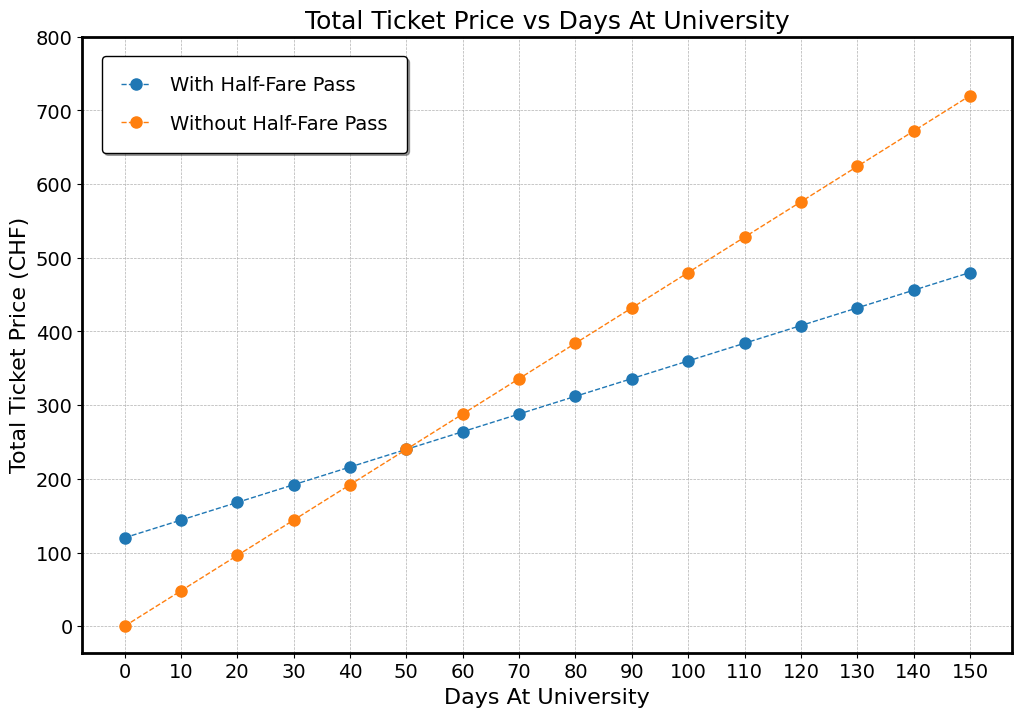

In [37]:
# Tests PolynomialModel with one predictor

#Creates figure and sets up axes, labels, and title
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.set_xlabel('Days At University')
ax.set_ylabel('Total Ticket Price (CHF)')
ax.set_title('Total Ticket Price vs Days At University')

#Stores data
days_at_uni = 150
ticket_price = 2.40 #Price of one ticket
number_tickets_day = 2 #Number of tickets bought per day
halffare_pass_price = 120 #Price of half-fare pass

#Creates parameter arrays
halffare_params = np.array([halffare_pass_price, ticket_price*number_tickets_day/2]).reshape(-1, 1)
nohalffare_params = np.array([0, ticket_price*number_tickets_day]).reshape(-1, 1)

# Creates predictor matrix for linear model
predictors = np.arange(start=0, stop=days_at_uni+1, step=10, dtype=np.int32) #Generates predictor values
predictors_matrix = FormPredictorMatrix(predictors, order=1, include_interaction=True)

#Computes model response
halffare_model = PolynomialModel(predictors_matrix, halffare_params)
nohalffare_model = PolynomialModel(predictors_matrix, nohalffare_params)

#Plots data
ax.plot(predictors, halffare_model, label='With Half-Fare Pass',
        linestyle='--', marker='o', linewidth=1, markersize=8)
ax.plot(predictors, nohalffare_model, label='Without Half-Fare Pass',
        linestyle='--', marker='o', linewidth=1, markersize=8)

#Adds legend and grid
ax.set_xticks(predictors)
ax.set_yticks(np.arange(0, np.max(nohalffare_model)+100, 100))
ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Saves plot
plt.savefig(CreateFilePath(r'\TotalTicketPriceVsDaysAtUniversity', extension='png'))

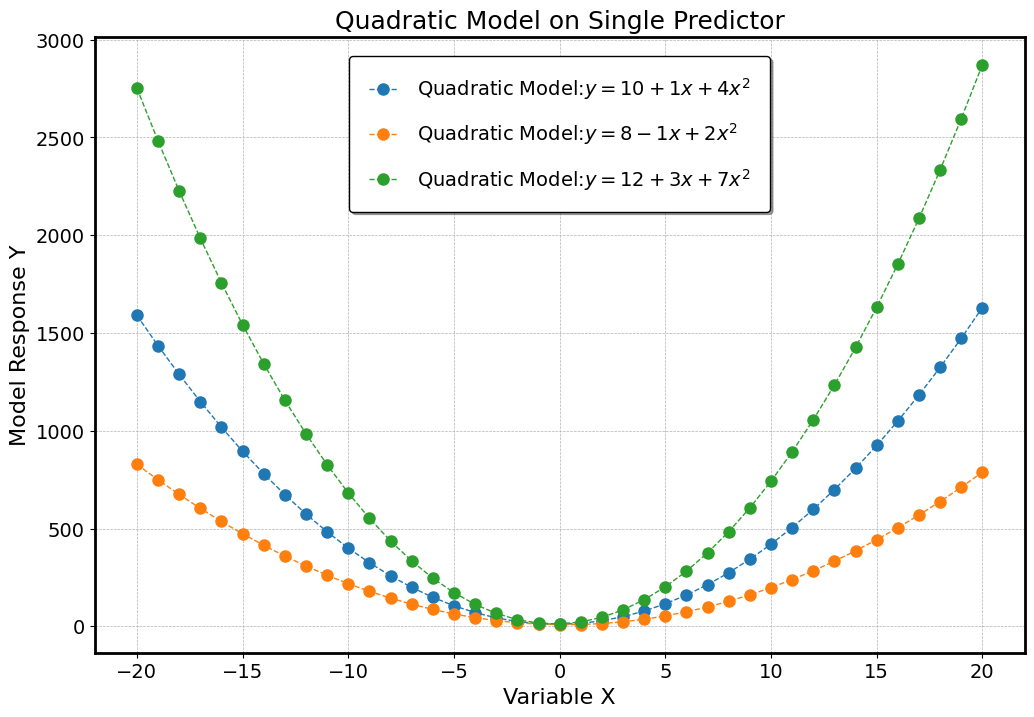

In [43]:
# Tests Quadratic On Single Predictor

#Creates figure and sets up axes, labels, and title
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.set_xlabel('Variable X')
ax.set_ylabel('Model Response Y')
ax.set_title('Quadratic Model on Single Predictor')

# Creates predictor matrix for quadratic model
predictors = np.linspace(start=-20, stop=20, num=41)
predictors_matrix = FormPredictorMatrix(predictors, order=2, include_interaction=False)

#Creates parameter and model array
params = np.array([[10, 1, 4], [8, -1, 2], [12, 3, 7]]).T
response = PolynomialModel(predictors_matrix, params)

#Plots results
labels = ['Quadratic Model:' + 
                f'$y = {params[0, index]}{FormString(params[1, index])}x{FormString(params[2, index])}x^2$'
                for index in range(params.shape[1])]
ax.plot(predictors, response, label=labels,
        linestyle='--', marker='o', linewidth=1, markersize=8)

#Adds legend and grid
ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Saves plot
plt.savefig(CreateFilePath(r'\QuadraticModelOnSinglePredictor', extension='png'))

In [39]:
# Tests PolynomialModel with multiple predictors

# Generates data
predictors_grid, predictors_flattened = CreateGrid([(-5, 5), (-5, 5)], num=20, transpose=False)

# Creates predictor matrix for quadratic model
predictors_matrix = FormPredictorMatrix(predictors_flattened, order=2, include_interaction=True)
print(f'Predictor Matrix: \n -Shape: {predictors_matrix.shape} \n -Values: \n {predictors_matrix}\n')

Predictor Matrix: 
 -Shape: (400, 6) 
 -Values: 
 [[ 1.         -5.         -5.         25.         25.         25.        ]
 [ 1.         -5.         -4.47368421 25.         22.36842105 20.01385042]
 [ 1.         -5.         -3.94736842 25.         19.73684211 15.58171745]
 ...
 [ 1.          5.          3.94736842 25.         19.73684211 15.58171745]
 [ 1.          5.          4.47368421 25.         22.36842105 20.01385042]
 [ 1.          5.          5.         25.         25.         25.        ]]



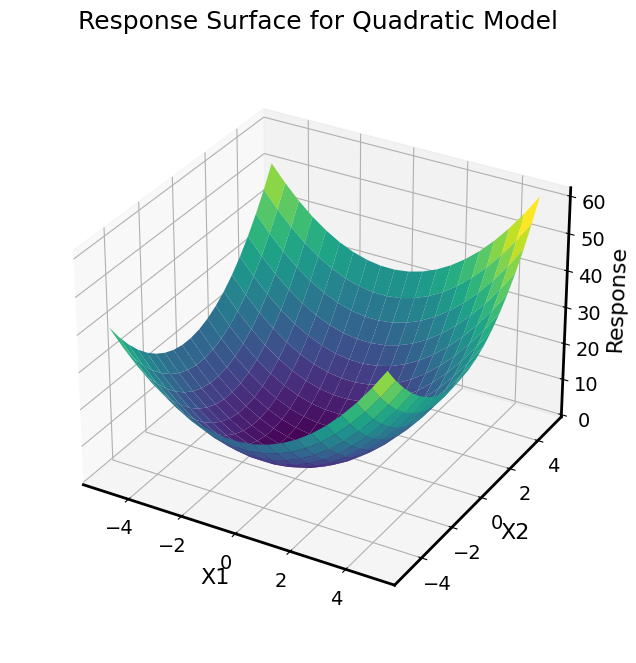

In [40]:
# Tests squared model

# Creates 3D figure and sets up axes, labels, and title
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Response')

# Computes response values
response = PolynomialModel(predictors_matrix, np.array([1, 1, 1, 1, 0, 1])).reshape(*predictors_grid[0].shape)

# Plots data
ax.plot_surface(predictors_grid[0], predictors_grid[1], response, cmap='viridis', edgecolor='none')

# Adds title
ax.set_title('Response Surface for Quadratic Model')
ax.label_outer()

# Zooms out plot
ax.set_box_aspect(aspect=None, zoom=0.90)
ax.zaxis.set_rotate_label(True)

# Saves plot
plt.savefig(CreateFilePath(r'\ResponseSurfaceForQuadraticModel', extension='png'))


Mean Squared Error: [[684.09776177]] 
Square Root of Mean Squared Error: [[26.1552626]]


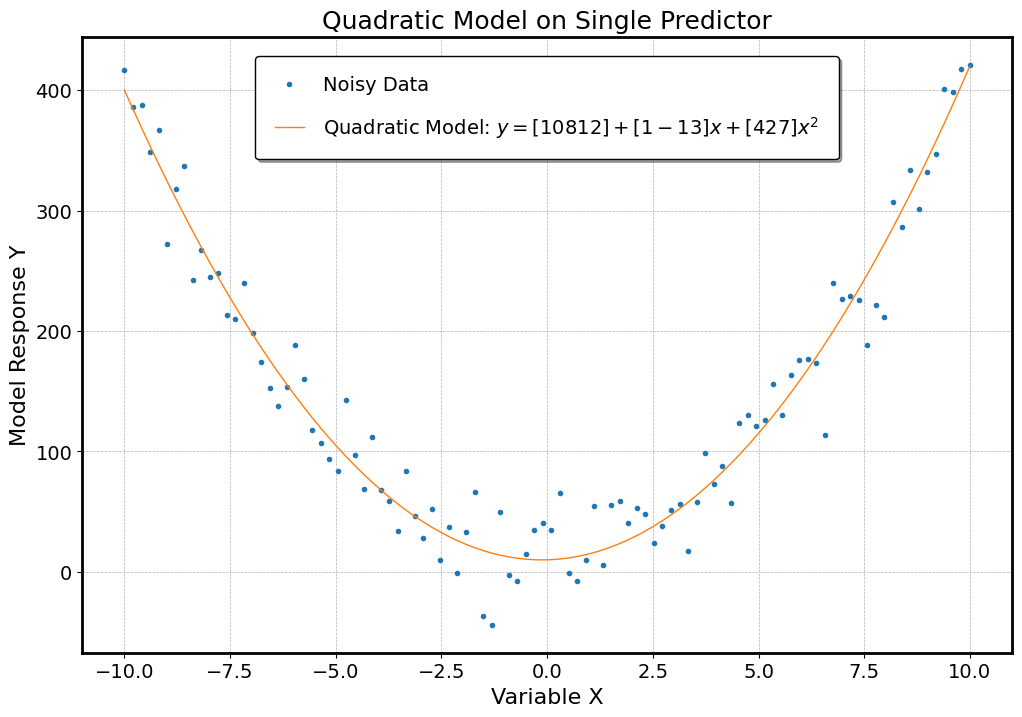

In [47]:
# Tests MeanSquareError by Adding Noise to Data

# Generates Data for Quadratic Single Predictor Model
predictors = np.linspace(start=-10, stop=10, num=100)
predictors_matrix = FormPredictorMatrix(predictors, order=2, include_interaction=False)
params_array = np.array([10, 1, 4])
model_response = PolynomialModel(predictors_matrix, params_array)

# Adds noise to response
noisy_response = AddRandomNoise(model_response, scale=25)

# Computes mean squared error
mse = MeanSquareError(model=PolynomialModel, response=noisy_response, predictors=predictors_matrix, params=params_array)
print(f'Mean Squared Error: {mse} \nSquare Root of Mean Squared Error: {np.sqrt(mse)}')

# Plots noisy data
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.set_xlabel('Variable X')
ax.set_ylabel('Model Response Y')
ax.set_title('Quadratic Model on Single Predictor')

#Plots results
ax.plot(predictors, noisy_response, label='Noisy Data',
        linestyle='', marker='o', linewidth=1, markersize=3)
ax.plot(predictors, model_response, label=f'Quadratic Model: $y = {params[0]} + {params[1]}x + {params[2]}x^2$',
        linestyle='-', linewidth=1)

#Adds legend and grid
ax.legend()
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Saves plot
plt.savefig(CreateFilePath(r'\NoisyQuadraticModelOnSinglePredictor', extension='png'))



In [62]:
# Creates array of params for testing on 2-parameter grid
param_grid, flattened_grid = CreateGrid([(-5, 5), (-5, 5)], num=51, transpose=True)

# Create predictor matrix for linear model with intercept
mesured_response = AddRandomNoise(arr=np.linspace(1, 5, 5).reshape(-1, 1), scale=10)
predictors_matrix = FormPredictorMatrix(predictors=np.linspace(-10, 10, 5), order=1, include_interaction=False)
model_response = PolynomialModel(predictors_matrix, flattened_grid)
difference = (mesured_response - model_response)**2 #Computes difference between measured and model response as 1-D array

# Logs shapes
print(f'Flattened Parameter Grid: {flattened_grid.shape}\n' 
    	+ f'Predictor Matrix: {predictors_matrix.shape}\n'
		+f'Measured Response: {mesured_response.shape}\n'
		+f'Model Response: {model_response.shape}\n'
		+f'Difference: {difference.shape}\n')

print(f'Mean Squared Error: {MeanSquareError(model=PolynomialModel, response=mesured_response, predictors=predictors_matrix, params=flattened_grid)}')

Flattened Parameter Grid: (2, 2601)
Predictor Matrix: (5, 2)
Measured Response: (5, 1)
Model Response: (5, 2601)
Difference: (5, 2601)

Mean Squared Error: [[ 1140.33342483  1096.77842903  1053.22343323 ... -1049.2195126
  -1092.7745084  -1136.3295042 ]
 [ 1096.77842903  1055.22343323  1013.66843742 ...  -996.7745084
  -1038.3295042  -1079.8845    ]
 [ 1053.22343323  1013.66843742   974.11344162 ...  -944.3295042
   -983.8845     -1023.4394958 ]
 ...
 [-1049.2195126   -996.7745084   -944.3295042  ...  1469.22754998
   1521.67255417  1574.11755837]
 [-1092.7745084  -1038.3295042   -983.8845     ...  1521.67255417
   1576.11755837  1630.56256257]
 [-1136.3295042  -1079.8845     -1023.4394958  ...  1574.11755837
   1630.56256257  1687.00756677]]


## Gradient Descent Algorithms

In [ ]:
def GD(func: Callable, params: list[np.ndarray], init: np.ndarray, eta: float, epochs: int) -> np.ndarray:
    
    func_value = func(*params.T)                           #Unpacks Parameters Along columns
    trajectory = np.zeros(shape=(epochs+1, init.shape[0])) #Empty array to store trajectory in parameter space
    trajectory[0, :] = init                                #Initial position in parameter space
    
    #Itrates over epochs to update parameter trajectory
    for iter in range(epochs):
        grad = np.grad(func_value)
        trajectory[iter+1, :] = trajectory[iter]
        trajectory[iter+1, :] -= eta*grad
    
    return trajectory

## Slower Functions

### Form Matrix Function
This function is used to create a predictor matrix for a polynomial model. It relies on an iteration over range(order) to create the matrix. The function has been tested for performance against the original function FormPredictorMatrix. The function "FormPredictorMatrix" is much faster than "FormPredictorMatrixOld" for large order of polynomials (Cross-over at 10), while for smaller orders differences are often negligibles. The function FormPredictorMatrix is recommended for creating predictor matrix for large order polynomial models and is currently being used over "FormPredictorMatrixOld".

In [ ]:
def FormPredictorMatrixOld(predictors: NDArray[Any], order: int=1) -> NDArray[Any]:
    
    # Ensures input is array
    predictors = np.asarray(predictors)
    
    # Create array to store predictor matrix
    predictor_matrix = np.ones(shape=(*predictors.shape[:-1], 1))
    if order==0:
        return predictor_matrix
    else:
        for exp in range(1, order+1):
            predictor_matrix = np.concatenate((predictor_matrix, predictors**exp), axis=-1)
        
    return predictor_matrix